c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:06:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 21374, number of negative: 7881
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 29255, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.730610 -> initscore=0.997720
[LightGBM] [Info] Start training from score 0.997720
📌 Balanced class weights: {0: 1.8560461870321026, 1: 0.6843595021989333}
Epoch 1/100


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


366/366 - 3s - 9ms/step - accuracy: 0.7947 - loss: 0.4273 - val_accuracy: 0.6999 - val_loss: 0.6724
Epoch 2/100
366/366 - 1s - 3ms/step - accuracy: 0.8013 - loss: 0.3944 - val_accuracy: 0.7778 - val_loss: 0.4187
Epoch 3/100
366/366 - 1s - 3ms/step - accuracy: 0.8037 - loss: 0.3870 - val_accuracy: 0.8130 - val_loss: 0.3745
Epoch 4/100
366/366 - 1s - 3ms/step - accuracy: 0.8138 - loss: 0.3801 - val_accuracy: 0.8088 - val_loss: 0.3825
Epoch 5/100
366/366 - 1s - 3ms/step - accuracy: 0.8117 - loss: 0.3756 - val_accuracy: 0.8193 - val_loss: 0.3875
Epoch 6/100
366/366 - 1s - 3ms/step - accuracy: 0.8121 - loss: 0.3743 - val_accuracy: 0.8176 - val_loss: 0.3638
Epoch 7/100
366/366 - 1s - 3ms/step - accuracy: 0.8113 - loss: 0.3717 - val_accuracy: 0.8166 - val_loss: 0.3613
Epoch 8/100
366/366 - 1s - 3ms/step - accuracy: 0.8094 - loss: 0.3725 - val_accuracy: 0.8043 - val_loss: 0.3674
Epoch 9/100
366/366 - 1s - 3ms/step - accuracy: 0.8101 - loss: 0.3694 - val_accuracy: 0.8228 - val_loss: 0.3510
Epoc

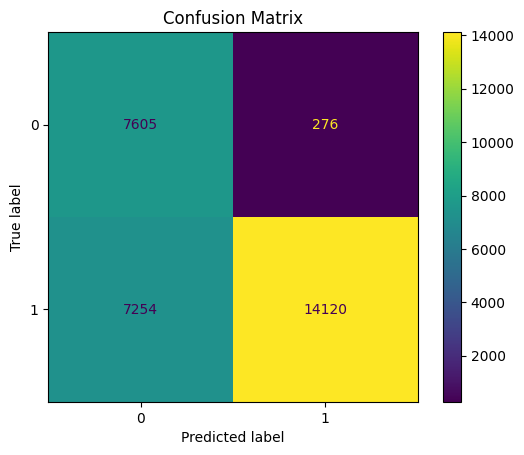

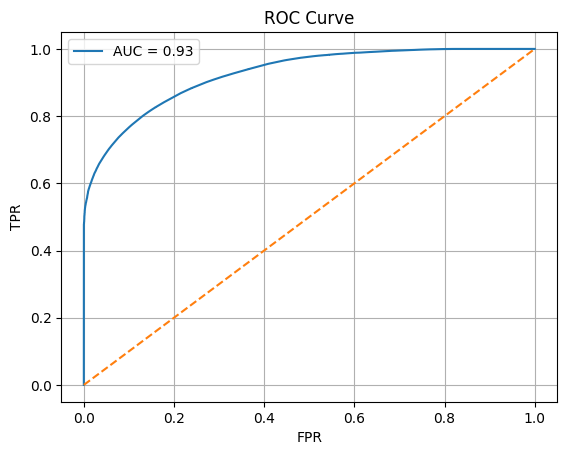


✅ Optimal Threshold (Max F1): 0.344469


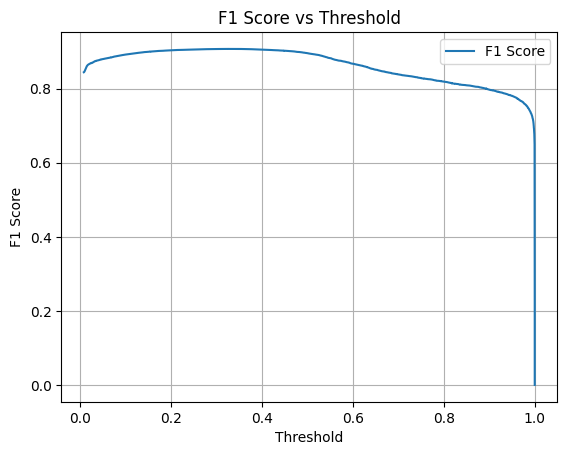

2741/2741 ━━━━━━━━━━━━━━━━━━━━ 2s 727us/step


: 

In [ ]:
# ✅ 匯入套件
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import gelu
from sklearn.utils.class_weight import compute_class_weight

# ✅ 讀取資料
X_train = pd.read_csv("X_train_pca.csv")
credit = pd.read_csv("credit_record.csv")
X_test = pd.read_csv("X_test_pca.csv")

# ✅ 標籤處理
credit["STATUS"] = credit["STATUS"].astype(str)
latest_status = credit.sort_values("MONTHS_BALANCE", ascending=False).groupby("ID")["STATUS"].first().reset_index()
X_train = X_train.drop_duplicates("ID", keep="first")
df = X_train.merge(latest_status, on="ID", how="left").dropna(subset=["STATUS"])
df["approved"] = df["STATUS"].apply(lambda x: 1 if x in ["0", "1", "C"] else 0)


X_base = df.drop(columns=["ID", "STATUS", "approved"]).values
y_base = df["approved"].values

# ✅ 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_base)
X_test_id = X_test["ID"]
X_test_scaled = scaler.transform(X_test.drop(columns=["ID"]).values)

# ✅ 訓練 base models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
lgb = LGBMClassifier(n_estimators=100, random_state=42)

rf.fit(X_scaled, y_base)
xgb.fit(X_scaled, y_base)
lgb.fit(X_scaled, y_base)

# ✅ 產生 meta features
rf_train = rf.predict_proba(X_scaled)[:, 1].reshape(-1, 1)
xgb_train = xgb.predict_proba(X_scaled)[:, 1].reshape(-1, 1)
lgb_train = lgb.predict_proba(X_scaled)[:, 1].reshape(-1, 1)

rf_test = rf.predict_proba(X_test_scaled)[:, 1].reshape(-1, 1)
xgb_test = xgb.predict_proba(X_test_scaled)[:, 1].reshape(-1, 1)
lgb_test = lgb.predict_proba(X_test_scaled)[:, 1].reshape(-1, 1)

X_meta_train = np.hstack([rf_train, xgb_train, lgb_train])
X_meta_test = np.hstack([rf_test, xgb_test, lgb_test])

# 自動平衡權重
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_base)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("📌 Balanced class weights:", class_weight_dict)

# ✅ 建立強化版 MLP 模型（GELU + L2 + class_weight）
model = Sequential([
    Dense(256, kernel_regularizer=l2(1e-4), input_shape=(3,)),
    Activation(gelu),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, kernel_regularizer=l2(1e-4)),
    Activation(gelu),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, kernel_regularizer=l2(1e-4)),
    Activation(gelu),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, kernel_regularizer=l2(1e-4)),
    Activation(gelu),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(X_meta_train, y_base,
          epochs=100, batch_size=64,
          callbacks=[early_stop],
          class_weight=class_weight_dict,
          verbose=2,
          validation_split=0.2)

# ✅ 評估訓練表現
val_pred_prob = model.predict(X_meta_train).flatten()
val_pred_label = (val_pred_prob > 0.92746305).astype(int)

print(classification_report(y_base, val_pred_label))
print("F1 score:", f1_score(y_base, val_pred_label))
print("AUC score:", roc_auc_score(y_base, val_pred_prob))

ConfusionMatrixDisplay(confusion_matrix(y_base, val_pred_label)).plot()
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_base, val_pred_prob)
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()

# ✅ PR Curve 與最佳 F1 threshold
precision, recall, thresholds = precision_recall_curve(y_base, val_pred_prob)
f1_scores = 2 * precision * recall / (precision + recall + 1e-6)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print("\n✅ Optimal Threshold (Max F1):", optimal_threshold)

plt.plot(thresholds, f1_scores[:-1], label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.grid()
plt.legend()
plt.show()

# ✅ 預測測試集結果
final_prob = model.predict(X_meta_test).flatten()
final_pred = (final_prob > optimal_threshold).astype(int)
